# Code Along: FastAI DL L8 - Pascal Object Detection

WNixalo - 1/5/2018

---

This notebook is a code along and warm up exercise. It follows the Fast.AI Deep Learning Lesson 8 Pascal notebook. [Lecture](https://youtu.be/b8D6Bwck9QM)|[Notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb)

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## 1. Setup

In [3]:
PATH = Path('../ext_data/pascal')
list(PATH.iterdir())

[PosixPath('../ext_data/pascal/tmp'),
 PosixPath('../ext_data/pascal/VOCdevkit'),
 PosixPath('../ext_data/pascal/pascal_train2012.json'),
 PosixPath('../ext_data/pascal/pascal_val2012.json'),
 PosixPath('../ext_data/pascal/models'),
 PosixPath('../ext_data/pascal/pascal_val2007.json'),
 PosixPath('../ext_data/pascal/pascal_train2007.json'),
 PosixPath('../ext_data/pascal/pascal_test2007.json')]

In [4]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [6]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [7]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

In [8]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [9]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/Annotations')]

In [10]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [11]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg'),
 PosixPath('../ext_data/pascal/VOCdevkit/VOC2007/JPEGImages/007666.jpg')]

In [12]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

In [13]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))

In [14]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [15]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [16]:
cats[7]

'car'

In [17]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [18]:
cats[15], cats[13]

('person', 'horse')

In [19]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1]+1, a[2]-a[0]+1])

In [20]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [21]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [22]:
# white box with black border
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [23]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [24]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top',color='white',fontsize=sz,weight='bold')
    draw_outline(text, 1)

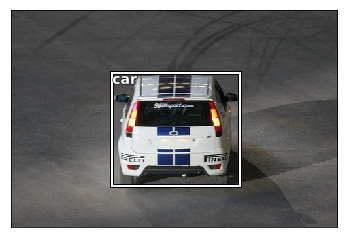

In [25]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]]) # b[:2] is top left

In [26]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [27]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


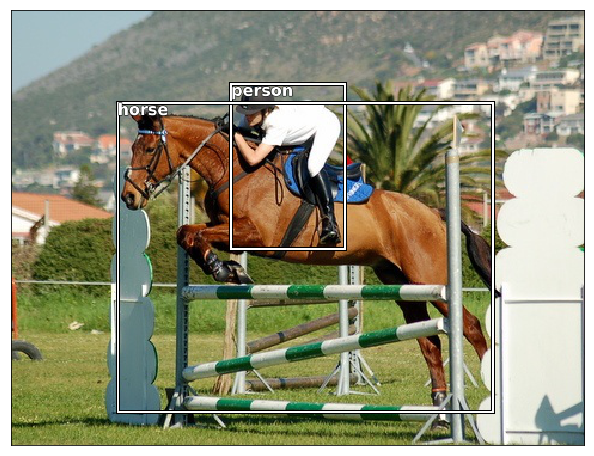

In [28]:
draw_idx(17)

## 2. Largest Item Classifier

[lecture8](https://youtu.be/b8D6Bwck9QM?t=4973)

In [29]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [39]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

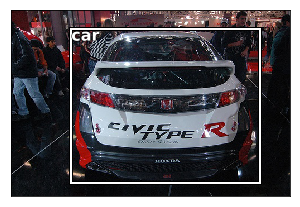

In [48]:
b,c = trn_lrg_anno[83]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[83]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [30]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [55]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [56]:
f_model = resnet34
sz = 224
bs = 64

In [57]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md   = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [89]:
# x,y = next(iter(md.val_dl))
# show_img(md.val_ds.denorm(to_np(x))[0]);

In [62]:
# x[-1]

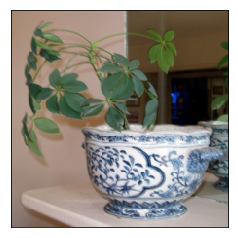

In [65]:
x,y = next(iter(md.trn_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [67]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

 78%|███████▊  | 25/32 [00:19<00:05,  1.26it/s, loss=10.1]

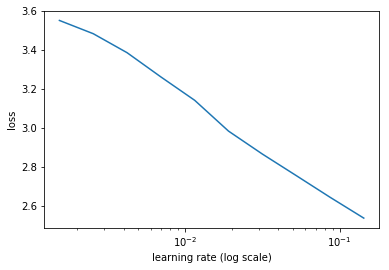

In [68]:
lrf = learn.lr_find(1e-5, 100)
learn.sched.plot()

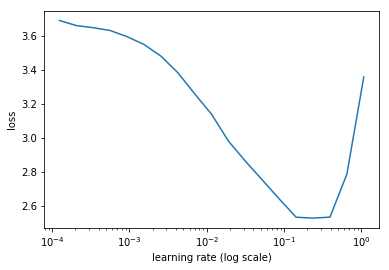

In [71]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [73]:
lr = 2e-2
learn.fit(lr, n_cycle=1, cycle_len=1)

 22%|██▏       | 7/32 [00:07<00:27,  1.08s/it, loss=2.23]
epoch      trn_loss   val_loss   accuracy                 
    0      1.317372   0.666263   0.81      



[array([0.66626]), 0.8099999976158142]

In [74]:
lrs = np.array([lr/1e3, lr/1e2, lr])
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:22<00:04,  1.18it/s, loss=5.08] 

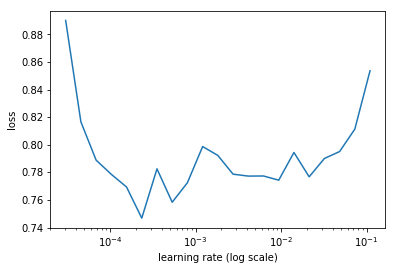

In [75]:
lrf = learn.lr_find(lrs/1e3)
learn.sched.plot(1)

In [77]:
learn.fit(lrs/5, n_cycle=1, cycle_len=1)

  0%|          | 0/32 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                  
    0      0.796449   0.535392   0.84      



[array([0.53539]), 0.8399999976158142]

In [78]:
learn.unfreeze()

In [79]:
learn.fit(lrs/5, n_cycle=1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.622001   0.50324    0.838     
    1      0.462104   0.496692   0.844                     



[array([0.49669]), 0.8439999990463257]

In [80]:
learn.save('clas_one')
# learn.load('clas_one')

In [83]:
# x,y = next(iter(md.val_dl)) # use md.val_dl to match lesson otuput
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

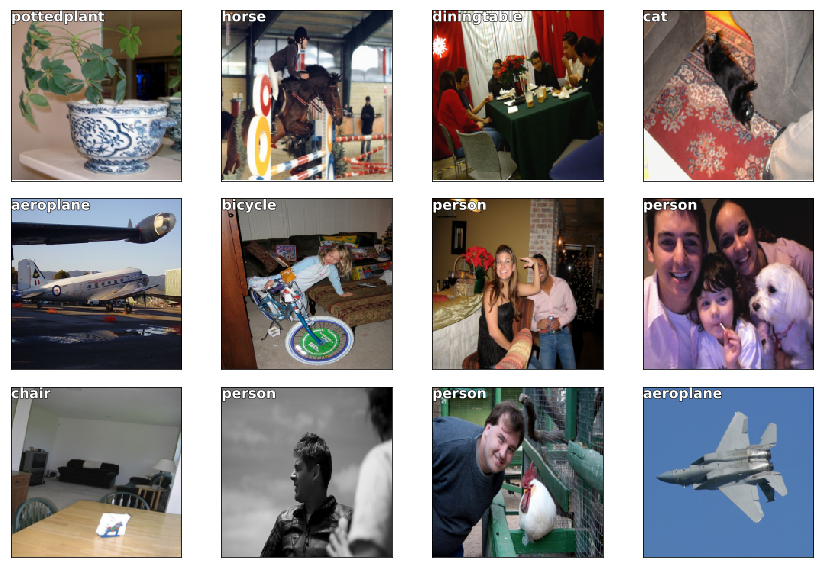

In [84]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## 3. Bounding Box Only

λecture8 | [lecture9](https://youtu.be/2HKbG7bGRIM?t=327)

In [31]:
BB_CSV = PATH/'tmp/bb.csv'

In [99]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [100]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [101]:
f_model = resnet34
sz = 224
bs = 64

In [116]:
augs = [RandomFlip(), RandomRotate(30), RandomLighting(0.1, 0.1)]

In [117]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]


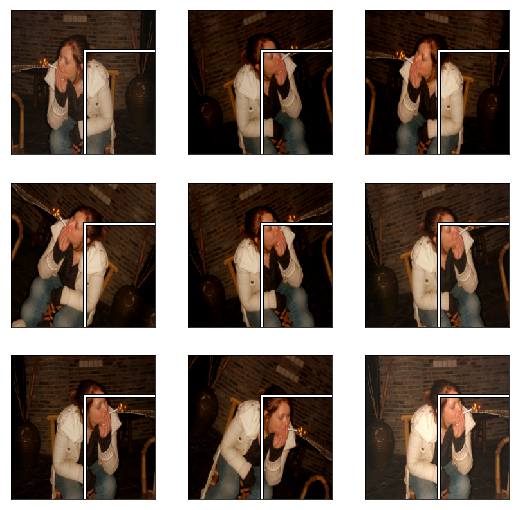

In [118]:
def show_augs():
    idx = 3
    fig,axes = plt.subplots(3, 3, figsize=(9,9))
    for i,ax in enumerate(axes.flat):
        x,y = next(iter(md.aug_dl))
        ima = md.val_ds.denorm(to_np(x))[idx]
        b = bb_hw(to_np(y[idx]))
        print(b)
        show_img(ima, ax=ax)
        draw_rect(ax, b)
show_augs()

In [34]:
augs = [RandomFlip(tfm_y=TfmType.COORD), 
        RandomRotate(30, tfm_y=TfmType.COORD), 
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [120]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md   = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 37.  22. 145. 201.]
[ 52.  38. 106. 183.]
[ 66.  38. 105. 183.]
[ 37.  22. 146. 201.]
[ 41.  26. 135. 197.]
[ 36.  19. 153. 204.]
[ 28.  16. 145. 207.]
[ 25.  13. 151. 210.]
[ 52.  37. 107. 186.]


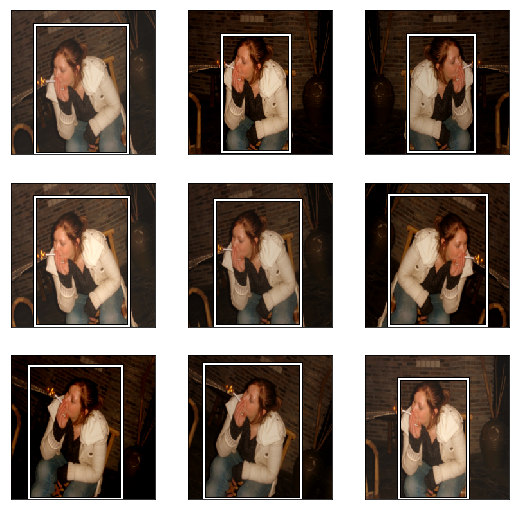

In [123]:
show_augs()

In [124]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y), 
        RandomRotate(3, p=0.5, tfm_y=tfm_y), 
        RandomLighting(0.05, 0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md   = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [125]:
x,y = next(iter(md.val_dl))
ima = md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 49.,   0., 132., 206.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


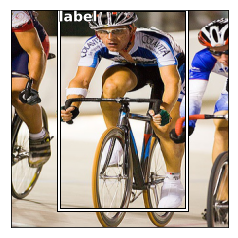

In [126]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [132]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4)) #RN34 last Conv layer: 7x7x512=25088
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [ ]:
# learn.summary()

 81%|████████▏ | 26/32 [00:24<00:05,  1.07it/s, loss=606] 

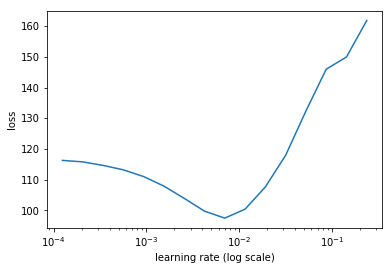

In [133]:
learn.lr_find(1e-5, 100)
learn.sched.plot(5)

In [135]:
lr = 2e-3
learn.fit(lr, n_cycle=2, cycle_len=1, cycle_mult=2)

  0%|          | 0/32 [00:00<?, ?it/s]
epoch      trn_loss   val_loss                            
    0      49.049311  33.844812 
    1      37.508779  28.519181                           
    2      31.632126  27.283456                           



[array([27.28346])]

In [136]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)

epoch      trn_loss   val_loss                            
    0      70.418812  9440157090447.36



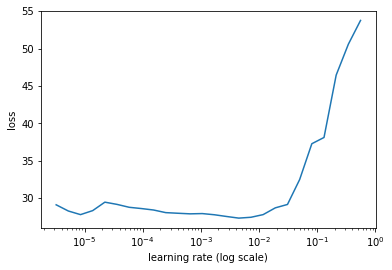

In [137]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [138]:
learn.fit(lrs, n_cycle=2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      25.868349  22.704834 
    1      22.75886   22.086606                           
    2      19.559353  19.848692                           



[array([19.84869])]

In [139]:
learn.freeze_to(-3)
learn.fit(lrs, n_cycle=1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      18.746475  21.242955 
    1      16.555923  19.389067                           



[array([19.38907])]

In [140]:
learn.save('reg4')
# learn.load('reg4')

In [141]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


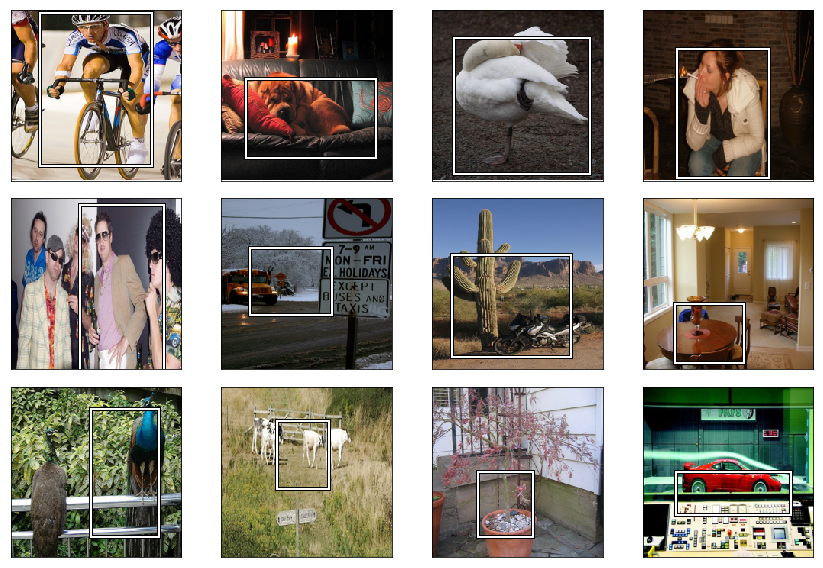

In [142]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## 4. Single Object Detection

[λecture9](https://youtu.be/2HKbG7bGRIM?t=641)

In [32]:
f_model = resnet34
sz = 224
bs = 64

val_idxs = get_cv_idxs(len(trn_fns))

In [35]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md   = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, 
                                    continuous=True, val_idxs=val_idxs)

In [36]:
md2  = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [37]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2 #y2 new dep var to add
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i])) # so: x[i], and (y[i], y2[i])

In [38]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [39]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [40]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [41]:
x,y = next(iter(md.val_dl))
idx = 2
ima = md.val_ds.ds.denorm(to_np(x))[idx]
b   = bb_hw(to_np(y[0][idx])); b

array([ 30.,  23., 175., 183.])

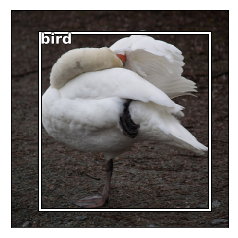

In [42]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

---
[λecture9 - architecture](https://youtu.be/2HKbG7bGRIM?t=834)

In [43]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(), 
    nn.Dropout(0.5), 
    nn.Linear(25088,256), 
    nn.ReLU(), 
    nn.BatchNorm1d(256), 
    nn.Dropout(0.5), 
    nn.Linear(256, 4+len(cats)), # use L1Loss for 1st 4; CE for cats
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [44]:
def detn_loss(input, target): # 'detection loss'
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:] # [batch, 1st-4:last-4]
    bb_i = F.sigmoid(bb_i)*224 # bbx size: 0-224; help NN by constraining that range
    # scale factor found by testing (λ1 & CE ~ same size)
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i   = input[:, :4]
    bb_i   = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i   = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 94%|█████████▍| 30/32 [00:26<00:01,  1.15it/s, loss=464]

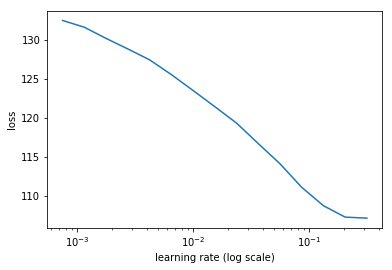

In [48]:
learn.lr_find()
learn.sched.plot()

In [49]:
lr = 1e-2
learn.fit(lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

  0%|          | 0/32 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      79.631939  47.59869   0.804      34.326455 
    1      56.515806  39.614396  0.796      27.139188     
    2      47.475478  38.604904  0.824      26.428497     



[array([38.6049]), 0.8239999995231628, 26.4284970703125]

In [50]:
learn.save('reg1_0')
# learn.load('reg1_0')

In [51]:
learn.freeze_to(-2)
lrs = np.array([lr/100, lr/10, lr])

 91%|█████████ | 29/32 [00:29<00:03,  1.00s/it, loss=223] 

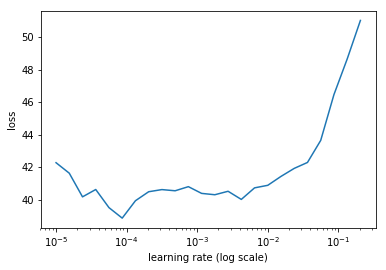

In [52]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [53]:
learn.fit(lrs/5, n_cycle=1, cycle_len=5, use_clr=(32,10))

 12%|█▎        | 4/32 [00:08<00:56,  2.01s/it, loss=40.2]
epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      41.013545  38.396265  0.79       24.675506 
    1      36.113223  35.434989  0.812      22.665533     
    2      31.871874  32.330363  0.826      21.065025     
    3      28.298382  33.168934  0.814      21.152149     
    4      25.955596  32.341595  0.82       20.808723     



[array([32.3416]), 0.8199999980926513, 20.808722686767577]

In [54]:
learn.save('reg1_1')
# learn.load('reg1_1')

In [55]:
learn.unfreeze()

In [56]:
learn.fit(lrs/10, n_cycle=1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      22.543231  32.694372  0.812      20.618574 
    1      22.529649  33.730277  0.816      20.63971      
    2      21.808237  33.557217  0.8        20.444821     
    3      20.900918  32.729873  0.808      19.742135     
    4      19.937765  33.166919  0.81       19.785257     
    5      19.060878  32.479448  0.808      19.290809     
    6      18.284457  32.344882  0.814      19.150186     
    7      17.623332  31.944823  0.814      19.476534     
    8      16.85023   31.429707  0.81       18.951137     
    9      16.35951   31.50738   0.808      19.063184     



[array([31.50738]), 0.808, 19.063183700561524]

In [57]:
learn.save('reg1')
# learn.load('reg1')

In [58]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [59]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


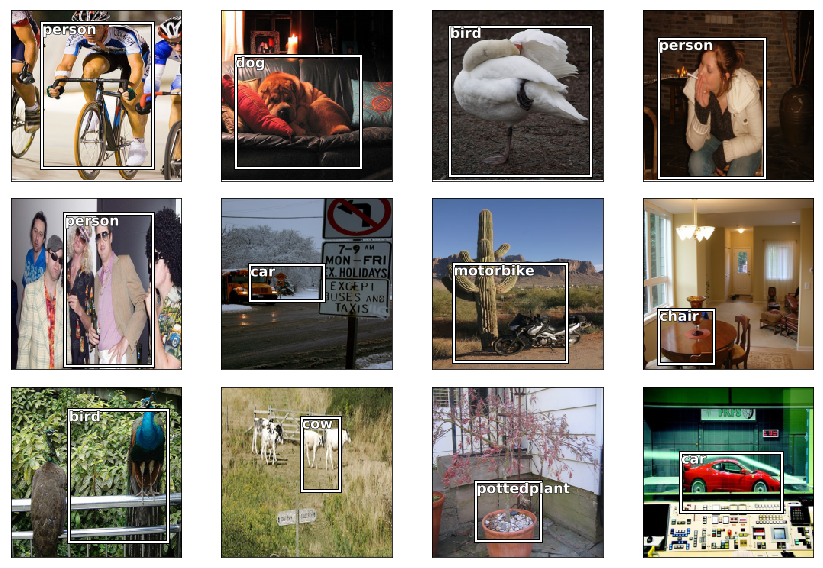

In [60]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

## debugging

 94%|█████████▍| 30/32 [00:25<00:01,  1.19it/s, loss=411]

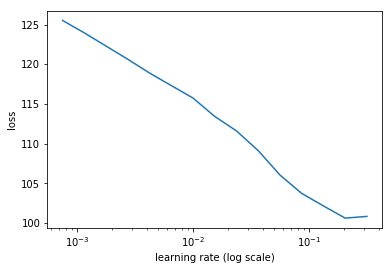

In [177]:
learn.lr_find()
learn.sched.plot()

In [179]:
lr=1e-2
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

  0%|          | 0/32 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'data'

In [ ]:
2

In [182]:
% debug

> /home/ubuntu/Aersu/GLOC/model_dev/fastai/model.py(213)<listcomp>()
    211             else: batch_cnts.append(len(x))
    212             loss.append(to_np(l))
--> 213             res.append([f(preds.data,y.data) for f in metrics])
    214     return [np.average(loss, 0, weights=batch_cnts)] + list(np.average(np.stack(res), 0, weights=batch_cnts))
    215 

ipdb> y[0]
Variable containing:
    0    49   205   180
   63     1   222   223
   23    30   205   204
   38    52   222   158
   17   102   222   178
   92     0   142    74
  150    81   207   206
  159    19   222   123
    6   149   218   202
   53   136   108   169
    2     1   222   223
   95    53   138   181
  105   102   214   221
   22     6   217   196
   45    31   191   187
   53    15   213   221
   84   192   222   223
   49   116   213   196
   41    56   183   142
   16    72   144   165
   55    25   221   187
  106   173   185   207
   13     1   222   151
    1     7   221   222
   34    54   207   175
   34

Issue resolved: [fastai forum thread](http://forums.fast.ai/t/attributeerror-list-object-has-no-attribute-data/15301). validate in model.py should do f(preds.data, y), not f(preds.data, y.data) -- since y here is a tuple of 2 tensors (bboxes & classes) and thus has no .data attribute.